[View in Colaboratory](https://colab.research.google.com/github/hypetrainai/hypetrain/blob/deepkaraoke/deepkaraoke/karaoke_mp3_preprocess.ipynb)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import random
import scipy
import scipy.io.wavfile
import scipy.signal
import librosa
import shutil
import tempfile

In [79]:
#@title Parse data dir for *.mp3 and *_OffVocal.mp3

SAMPLE_RATE = 24000
TARGET_SAMPLE_RATE = 16000
data_dir = '/mnt/z/Dropbox/hypetrain_data/karaoke/16k_LARGE_FIXED' #@param
print('Loading from %s' % data_dir)

off_vocal_files = sorted(glob.glob(os.path.join(data_dir, '*_OffVocal.mp3')))
on_vocal_files = [f.replace('_OffVocal', '') for f in off_vocal_files]
print('Loaded %d files' % len(off_vocal_files))

Loading from /mnt/c/Users/jonathanasdf/Desktop/rightfully
Loaded 1 files


In [74]:
def FindInSeq(seq, pattern):
    """Finds 'pattern' in 'seq'.
  
    The pattern will be perfectly aligned to seq, but there may be a signal that's
    been added or removed. This tries to find that alignment.
  
    Args:
        seq: the sequence containing the pattern to find, with an additional signal
            either added or removed.
        pattern: the pattern to find. Must be no longer than seq. Must be reasonably
            close to the length of seq.
      
    Raises:
        ValueError if the pattern is longer than seq or is much shorter than seq.
  
    Returns:
        the index of 'pattern' in 'seq'.
    """
    if len(seq) < len(pattern):
        raise ValueError('seq must not be shorter than pattern.')
    if len(seq) - len(pattern) > 5 * SAMPLE_RATE:
        raise ValueError('The 2 sequences have very different lengths!')
    seq = seq / np.std(seq)
    pattern = pattern / np.std(pattern)
    pad = 2 * SAMPLE_RATE
    seq = np.concatenate([np.zeros(pad), seq, np.zeros(pad)])
    corr = scipy.signal.correlate(seq, pattern, 'valid', 'fft')
    shift = np.argmax(corr) - pad
    if shift != 0:
        plt.plot(np.array(range(len(corr))) - pad, corr)
        plt.show()
    return shift

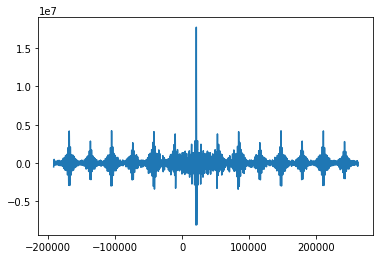

Rightfully.flac: shifting by 21150.
multiplying by 0.997877.


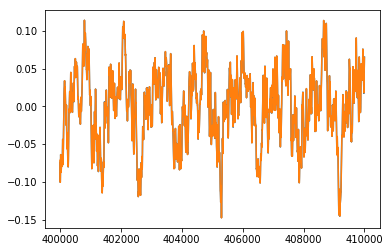

In [82]:
all_data = []
for on_vocal, off_vocal in zip(on_vocal_files, off_vocal_files):
    songfilename = os.path.basename(on_vocal)
    tmpdir = tempfile.mkdtemp()
    filename = os.path.join(tmpdir, 'on_vocal.wav')
    !sox "$on_vocal" -e floating-point "$filename" remix -
    data_on = scipy.io.wavfile.read(filename)

    filename = os.path.join(tmpdir, 'off_vocal.wav')
    !sox "$off_vocal" -e floating-point "$filename" remix -
    data_off = scipy.io.wavfile.read(filename)
    shutil.rmtree(tmpdir)
  
    assert data_on[0] == data_off[0] == SAMPLE_RATE
    a, b = data_on[1][:], data_off[1][:]
    swapped = False
    if len(a) < len(b):
        a, b = b, a
        swapped = True

    shift = FindInSeq(a, b)
    print('%s: shifting by %d.' % (os.path.basename(on_vocal), shift))
    if shift < 0:
        b = b[-shift:]
        shift = 0
    a = a[shift:shift+len(b)]
    if len(a) < len(b):
        b = b[:len(a)]
    # c = scipy.optimize.minimize_scalar(lambda c: -np.sum(np.abs(c*b - a) < 1e-3)).x
    c = 1.0
    print('multiplying by %f.' % c)
    b = c * b
    # Normalize volume and resample
    n = max(np.amax(np.abs(a)), np.amax(np.abs(b)))
    a = librosa.core.resample(a/n, SAMPLE_RATE, TARGET_SAMPLE_RATE)
    b = librosa.core.resample(b/n, SAMPLE_RATE, TARGET_SAMPLE_RATE)
    data_on, data_off = a, b
    all_data.append((os.path.basename(on_vocal), data_on, data_off))
  
    plot_len = 10000
    step = 1
    start = 400000
    plt.plot(range(start, start + plot_len, step), data_on[start:start+plot_len:step], label="data_on")
    plt.plot(range(start, start + plot_len, step), data_off[start:start+plot_len:step], label="data_off")
    plt.show()

In [83]:
problem_children = ['AmenoKaze','AkakuYurameku', 'Astro=Hope','BakerBakerParadox','HalloweenNightParade','JedarunoKaikou',
'Landscape','LittleBadSong', 'MasshironoYuki','MetempsychosisBlossoms','MindTrigger', 'Moonscraper','ShinoShoujo','Spherelight','Sprite100',
'TrickorDream','WalkAlone','RigurusunoKodoku']
problem_children = [string + '.mp3' for string in problem_children]
print(problem_children)

for idx in range(len(all_data)):
    if all_data[idx][0] in problem_children:
        scipy.io.wavfile.write('data/check_these/'+all_data[idx][0].replace('.mp3','OnVocalShifted.wav'), TARGET_SAMPLE_RATE, all_data[idx][1])
        scipy.io.wavfile.write('data/check_these/'+all_data[idx][0].replace('.mp3','OffVocalShifted.wav'), TARGET_SAMPLE_RATE, all_data[idx][2])
        
for idx in range(len(all_data)):
    scipy.io.wavfile.write('data/check_these/'+all_data[idx][0].replace('.mp3','Diff.wav'), TARGET_SAMPLE_RATE, all_data[idx][1]-all_data[idx][2])

['AmenoKaze.mp3', 'AkakuYurameku.mp3', 'Astro=Hope.mp3', 'BakerBakerParadox.mp3', 'HalloweenNightParade.mp3', 'JedarunoKaikou.mp3', 'Landscape.mp3', 'LittleBadSong.mp3', 'MasshironoYuki.mp3', 'MetempsychosisBlossoms.mp3', 'MindTrigger.mp3', 'Moonscraper.mp3', 'ShinoShoujo.mp3', 'Spherelight.mp3', 'Sprite100.mp3', 'TrickorDream.mp3', 'WalkAlone.mp3', 'RigurusunoKodoku.mp3']


In [58]:
import sys

idx = np.array(range(len(all_data)))
np.random.seed(12345678)
#np.random.shuffle(idx)
num_train = int(0.75 * len(all_data))

test_files = ['Dearest.mp3', 'KazegaSaeruyoriHayaku.mp3', 'Encounter.mp3', 'KyoumeiShinaiAinoKatachi.mp3']

train_data = {}
test_data = {}
for i in range(len(all_data)):
    filename, data_on, data_off = all_data[idx[i]]
    assert len(data_on) == len(data_off)
    if filename in test_files:
        test_data[filename] = data_on, data_off
    else:
        train_data[filename] = data_on, data_off

output_dir = '/mnt/z/Dropbox/projects/hypetrain/deepkaraoke/data'
print('Train:', train_data.keys())
with open(os.path.join(output_dir, 'train.pkl.gz'), 'wb') as f:
    pickle.dump(train_data, f, protocol=pickle.HIGHEST_PROTOCOL)

print('Test:', test_data.keys())
with open(os.path.join(output_dir, 'test.pkl.gz'), 'wb') as f:
    pickle.dump(test_data, f, protocol=pickle.HIGHEST_PROTOCOL)

('Train:', ['JinjatoHitotoPikopikonoRekishi.mp3', 'Stargazer.mp3', 'SewoKogasuShukumei.mp3', 'LieToMe.mp3', 'KoinoSerenade.mp3', 'AnatawoMamoruKentoNarou.mp3', 'AmenoLive.mp3', 'LaplaceFantasia.mp3', 'HanoGotoku.mp3', 'Reincarnation.mp3', 'MahougaUmaretaHi.mp3', 'Air.mp3', 'MikitekiRenaiGusha.mp3', 'GanbareJukensei.mp3', 'UchuunoKodomo.mp3', 'UkyounoShinzou.mp3', 'MindTrigger.mp3', 'Depressing.mp3', 'Astro=Hope.mp3', 'AkakuYurameku.mp3', 'Moonscraper.mp3', 'HitareKanbiTaruKaimu.mp3', 'HalloweenNightParade.mp3', 'MetempsychosisBlossoms.mp3', 'SoranoLive.mp3', 'Poisonbody.mp3', 'UpTensionPlease.mp3', 'SagiriNoTomoshibi.mp3', 'Moonlight.mp3', 'GetYourPartyOn.mp3', 'HatsukoiStroke.mp3', 'MasshironoYuki.mp3', 'SuiseiTrip.mp3', 'Aria.mp3', 'Spherelight.mp3', 'HitotsunoNegai.mp3', 'Innocence.mp3', 'FarAwayHighWay.mp3', 'Sprite100.mp3', 'SutekinaHakabadeKurashimashou.mp3', 'TrickorDream.mp3', 'ShinchokuDouDesuKa.mp3', 'Landscape.mp3', 'ChiyoriUtau.mp3', 'HitodenashiRomanesque.mp3', 'LittleBadS